In [1]:
import sys
import os
from glob import glob
import pickle
import os
import urllib
from functools import reduce
from collections import deque
import gc

from joblib import Parallel, delayed

from tqdm import tqdm

import numpy as np

from scipy.ndimage import convolve

import pandas as pd

from PIL import Image
from PIL import ImageEnhance

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms.functional as TF

sys.path.insert(0, os.getcwd())

# import all utils
from utils import data_directory, \
                dinov3_repo_dir, \
                dinov3_vitb16_weight_raw, \
                dinov3_vith16_weight_raw, \
                dinov3_vit7B16_weight_raw, \
                dinov3_vits16p_weight_raw
                
sys.path.insert(0, os.path.join(dinov3_repo_dir))
    

In [6]:
def count_components_floodfill(row:dict, connectivity: int = 8):
    """
    Count connected True components in a 2D boolean numpy mask using flood-fill (iterative).
    Args:
        mask: 2D boolean numpy array
        connectivity: 4 or 8 (neighbour connectivity)
    Returns:
        n_components: int
        sizes: list of int (size of each component)
        labels: 2D int32 array same shape as mask where 0 = background, 1..n = component ids
    """
    mask = row['bool_mask']
    
    assert mask.ndim == 2, "mask must be 2D"
    assert connectivity in (4, 8)
    H, W = mask.shape
    visited = np.zeros((H, W), dtype=bool)
    # labels = np.zeros((H, W), dtype=np.int32)
    neighbors4 = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    neighbors8 = neighbors4 + [(-1, -1), (-1, 1), (1, -1), (1, 1)]
    neighbors = neighbors8 if connectivity == 8 else neighbors4

    comp_id = 0
    # sizes = []

    for y in range(H):
        for x in range(W):
            if mask[y, x] and not visited[y, x]:
                comp_id += 1
                q = deque()
                q.append((y, x))
                visited[y, x] = True
                # labels[y, x] = comp_id
                # size = 0
                while q:
                    cy, cx = q.popleft()
                    # size += 1
                    for dy, dx in neighbors:
                        ny, nx = cy + dy, cx + dx
                        if 0 <= ny < H and 0 <= nx < W and not visited[ny, nx] and mask[ny, nx]:
                            visited[ny, nx] = True
                            # labels[ny, nx] = comp_id
                            q.append((ny, nx))
                # sizes.append(size)

    return {"name":row["name"], "index":row["index"], "bool_mask":mask, "n_comps":comp_id} #, sizes, labels


forged_folder = os.path.join(data_directory, 'train_images', 'forged')
authentic_folder = os.path.join(data_directory, 'train_images', 'authentic')
mask_folder = os.path.join(data_directory, 'train_masks')

PATCH_SIZE = 16
DEFAULT_IMAGE_SIZE = 512 # Should be multiple of PATCH_SIZE
MASK_THRESHOLD = 0

# def resize_image_to_fit_patch(
#     image: Image,
#     image_size: int = DEFAULT_IMAGE_SIZE,
#     patch_size: int = PATCH_SIZE,
# ) -> Image:
#     w, h = image.size
#     h_hat = image_size
#     w_hat = PATCH_SIZE * int(((w/h)*image_size)// PATCH_SIZE)
#     resized_img = image.resize((w_hat, h_hat), \
#                     resample=Image.Resampling.LANCZOS)
#     return resized_img

def resize_image_to_fit_patch(
    image: Image,
    image_size: int = DEFAULT_IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> Image:
    w, h = image.size
    w_hat = h_hat = PATCH_SIZE * (image_size // PATCH_SIZE)
    resized_img = image.resize((w_hat, h_hat), \
                    resample=Image.Resampling.LANCZOS)
    return resized_img

def resized_image_to_mask(image_resized, mask_threshold: int = MASK_THRESHOLD):
    image_array = np.array(image_resized)
    mask = image_array > mask_threshold
    return mask

def mask_to_resized_image(mask):
    image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
    image_resized = resize_image_to_fit_patch(image)
    return image_resized

def resize_mask_to_fit_patch(
    mask: np.ndarray,
    mask_threshold: int = MASK_THRESHOLD,
) -> np.ndarray:
    resized_image = mask_to_resized_image(mask)
    return resized_image_to_mask(resized_image)

def pixel_to_patch_coords(y_pixel, x_pixel, patch_size=PATCH_SIZE):
    y_coord = y_pixel // patch_size
    x_coord = x_pixel // patch_size
    return y_coord, x_coord

# Convert auth_mask to patch coordinates and mask the similarity map
def pixel_mask_to_patch_float(pixel_mask, patch_size=PATCH_SIZE):
    """Convert pixel-level mask to patch-level mask"""
    H_pixels, W_pixels = pixel_mask.shape
    H_patches = H_pixels // patch_size
    W_patches = W_pixels // patch_size
    
    patch_mask = np.zeros((H_patches, W_patches), dtype=float)
    
    for i in range(H_patches):
        for j in range(W_patches):
            # Check if any pixel in this patch is True
            patch_region = pixel_mask[i*patch_size:(i+1)*patch_size, 
                                     j*patch_size:(j+1)*patch_size]
            patch_mask[i, j] = np.sum(patch_region) / (patch_size * patch_size)
    
    return patch_mask

def load_10_mask_entities(name=None, idxs=None):
    all_mask_entities = []
    if name is not None and idxs is not None:
        for idx in idxs:
            file = os.path.join("mask_entities", f"{name}_{idx}.pkl")
            all_mask_entities.append(pickle.load(open(file, 'rb')))
        return all_mask_entities
    files = glob(os.path.join("mask_entities", '*.pkl'))[:10]
    all_mask_entities = []
    for file in files:
        mask_entities = pickle.load(open(file, 'rb'))
        all_mask_entities.append(mask_entities)
    return all_mask_entities



### Extract Forged and Authentic Masks Separately

In [ ]:
def get_masks(mask_file):
    ret = []
    
    mask_name = os.path.basename(mask_file).replace('.npy', '')
    
    if os.path.exists(os.path.join(forged_folder, mask_name+'.png')) is False:
        return ret

    if os.path.exists(os.path.join(authentic_folder, mask_name+'.png')) is False:
        return ret
    
    masked_image_path = os.path.join(mask_folder, mask_name+'.npy')
    masked_imgs = np.load(masked_image_path)
    masked_imgs_shape = masked_imgs.shape
    
    for i in range(masked_imgs_shape[0]):
    
        # get the i-th mask
        masked_img = masked_imgs[i]

        # Convert masked_img to boolean
        masked_img_boolean = masked_img > MASK_THRESHOLD
        
        ret.append({"name":mask_name, "index":i, "bool_mask":masked_img_boolean})
    
    return ret

mask_files = glob(os.path.join(mask_folder, '*.npy'))
all_masks = Parallel(n_jobs=-1)(delayed(get_masks)(mask_file) for mask_file in tqdm(mask_files))
all_masks = [item for sublist in all_masks for item in sublist]
pickle.dump(all_masks, open('masks.pkl', 'wb'))

In [ ]:
all_masks = pickle.load(open('masks.pkl', 'rb'))
component_counts = Parallel(n_jobs=-1)(delayed(count_components_floodfill)(row) for row in tqdm(all_masks))
pickle.dump(component_counts, open('component_counts.pkl', 'wb'))



In [ ]:

def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def smooth_boolean_mask(mask, kernel_size=3):
    """
    Smooths a boolean pixel mask based on a majority vote of neighboring pixels.
    Kernel/accumulators use int32 to avoid overflow for large kernels.
    """
    if kernel_size % 2 == 0 or kernel_size < 3:
        raise ValueError("kernel_size must be an odd integer >= 3")

    # Use int32 to avoid overflow when summing large neighborhoods
    int_mask = mask.astype(np.int32)

    kernel = np.ones((kernel_size, kernel_size), dtype=np.int32)

    neighbor_sum = convolve(int_mask, kernel, mode='constant', cval=0)

    # majority threshold excluding center? here we keep original behavior:
    majority_threshold = (kernel_size * kernel_size) / 2

    new_mask = neighbor_sum > majority_threshold

    return new_mask.astype(bool)

def smooth_boolean_mask2(mask, kernel_size=3):
    """
    Smooth boolean mask: a pixel becomes False only if a strict majority of its neighbors
    (excluding itself) are False; otherwise it keeps its original value.

    Uses int32 accumulator to prevent overflow when kernel_size grows.
    """
    if kernel_size % 2 == 0 or kernel_size < 3:
        raise ValueError("kernel_size must be an odd integer >= 3")

    # Use int32 to avoid overflow
    int_mask = mask.astype(np.int32)

    kernel = np.ones((kernel_size, kernel_size), dtype=np.int32)

    # Convolve to get sum including center
    neighbor_sum_incl = convolve(int_mask, kernel, mode='constant', cval=0)

    # Sum of neighbors only (exclude the center pixel)
    neighbors_sum = neighbor_sum_incl - int_mask

    # Number of neighbors (excluding center)
    n_neighbors = kernel_size * kernel_size - 1

    # Count of False neighbors
    false_neighbors = n_neighbors - neighbors_sum

    # Majority threshold: strict majority of neighbors being False
    majority_threshold = n_neighbors // 2

    # New mask: keep original value unless majority of neighbors are False -> set False
    new_mask = mask.copy().astype(bool)
    majority_false = false_neighbors > majority_threshold
    new_mask[majority_false] = False

    return new_mask

def select_regions_with_high_iou(A: np.ndarray, B: np.ndarray, iou_threshold: float = 0.5):
    """
    Select regions in mask A that have IOU above threshold with any region in mask B.
    Returns a boolean mask of selected regions in A.
    """
    from scipy.ndimage import label

    # Label connected components in A and B
    labeled_A, num_A = label(A)
    labeled_B, num_B = label(B)

    selected_mask = np.zeros_like(A, dtype=bool)

    # For each region in A
    for a_idx in range(1, num_A + 1):
        region_A = labeled_A == a_idx
        max_iou = 0
        # Compare with each region in B
        for b_idx in range(1, num_B + 1):
            region_B = labeled_B == b_idx
            intersection = np.logical_and(region_A, region_B).sum()
            union = np.logical_or(region_A, region_B).sum()
            if union == 0:
                continue
            iou = intersection / union
            if iou > max_iou:
                max_iou = iou
        # If max IOU above threshold, select region
        if max_iou >= iou_threshold:
            selected_mask = np.logical_or(selected_mask, region_A)

    return selected_mask

def process_mask(row):
    
    mask_name = row["name"]
    
    # print(mask_name, row["index"])
    
    forged_image_path = os.path.join(forged_folder, mask_name+'.png')
    forged_img = Image.open(forged_image_path).convert('RGB')

    auth_image_path = os.path.join(authentic_folder, mask_name+'.png')
    auth_img = Image.open(auth_image_path).convert('RGB')
    
    # Subtract auth_img from forged_img and convert to boolean mask
    forged_array = np.mean(np.array(forged_img), axis=2)
    # forged_array = (forged_array - np.min(forged_array))/(np.max(forged_array) - np.min(forged_array))
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(forged_array, cmap='gray')
    # plt.title(f'Forged')
    # plt.axis('off')
    
    auth_array = np.mean(np.array(auth_img), axis=2)
    # auth_array = (auth_array - np.min(auth_array))/(np.max(auth_array) - np.min(auth_array))
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(auth_array, cmap='gray')
    # plt.title(f'Auth')
    # plt.axis('off')

    # Calculate absolute difference
    diff_array = np.abs(forged_array.astype(np.float32) - auth_array.astype(np.float32))

    # Convert to grayscale by taking mean across channels
    # diff_gray = np.mean(diff_array, axis=2)

    # Create boolean mask (threshold can be adjusted)
    DIFF_THRESHOLD = 0  # Adjust this value as needed
    diff_boolean_mask = diff_array > DIFF_THRESHOLD
    diff_boolean_mask = diff_boolean_mask.astype(bool)
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(diff_boolean_mask, cmap='gray')
    # plt.title(f'Diff')
    # plt.axis('off')
    
    
    if not np.any(diff_boolean_mask):
        return None
    
    # Smooth the diff boolean mask
    kernel_size = 3
    last_diff_boolean_mask = diff_boolean_mask.copy()
    it = 0
    while 1:
        while 1:
            it += 1
            prev_mask = diff_boolean_mask.copy()
            diff_boolean_mask = smooth_boolean_mask2(diff_boolean_mask, kernel_size=kernel_size)
            if np.array_equal(prev_mask, diff_boolean_mask):
                del prev_mask
                gc.collect()
                break
        
        n_comps = count_components_floodfill({"name":mask_name, \
                                    "index":-1, \
                                    "bool_mask":diff_boolean_mask})["n_comps"]
        kernel_size += 2
        if not np.any(diff_boolean_mask):
            break
        if np.array_equal(last_diff_boolean_mask, diff_boolean_mask):
            continue
        last_diff_boolean_mask = diff_boolean_mask
        if n_comps <= row["n_comps"]-1:
            break
        
    diff_boolean_mask = last_diff_boolean_mask
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(diff_boolean_mask, cmap='gray')
    # plt.title(f'Diff')
    # plt.axis('off')
    
    
    masked_img_boolean = row["bool_mask"]
    # masked_img_boolean = resize_mask_to_patch_dimensions(masked_img_boolean)
    
    #  # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(masked_img_boolean, cmap='gray')
    # plt.title(f'OG Mask')
    # plt.axis('off')
    
    
    # find intersections between diff_boolean_mask and masked_img_boolean
    forged_mask = np.logical_and(diff_boolean_mask, masked_img_boolean)
    if not np.any(diff_boolean_mask):
        return None
    
    # Smooth the boolean mask
    kernel_size = 3
    last_forged_mask = forged_mask.copy()
    it = 0
    while 1:
        while 1:
            it += 1
            prev_mask = forged_mask.copy()
            forged_mask = smooth_boolean_mask2(forged_mask, kernel_size=kernel_size)
            if np.array_equal(prev_mask, forged_mask):
                del prev_mask
                gc.collect()
                break
        n_comps = count_components_floodfill({"name":mask_name, \
                                    "index":-1, \
                                    "bool_mask":forged_mask})["n_comps"]
        kernel_size += 2
        if not np.any(forged_mask):
            break
        if np.array_equal(last_forged_mask, forged_mask):
            continue
        last_forged_mask = forged_mask
        if n_comps <= row["n_comps"]-1:
            break
    forged_mask = last_forged_mask
    
    # Select the regions with highest IOU
    forged_mask = select_regions_with_high_iou(A=masked_img_boolean, B=forged_mask, iou_threshold=0.85)
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(forged_mask, cmap='gray')
    # plt.title(f'Forged')
    # plt.axis('off')
    
    # get auth mask
    auth_mask = masked_img_boolean & ~forged_mask
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(auth_mask, cmap='gray')
    # plt.title(f'Auth')
    # plt.axis('off')


    me = {"mask_name": mask_name, \
                "index": row["index"], \
                "auth_mask": auth_mask, \
                "forged_mask": forged_mask,}
    
    pickle.dump(me, open(os.path.join('mask_entities', f'{mask_name}_{row["index"]}.pkl'), 'wb'))

component_counts = pickle.load(open('component_counts.pkl', 'rb'))

# chunk_size = 24  # adjust as needed
# total = len(component_counts)
# n_chunks = (total + chunk_size - 1) // chunk_size
# for chunk_idx, start in enumerate(range(0, total, chunk_size), 1):
#     end = min(start + chunk_size, total)
#     chunk = component_counts[start:end]
#     print(f"Processing chunk {chunk_idx}/{n_chunks} (items {start}:{end})")
#     # process this chunk in parallel
#     Parallel(n_jobs=-1)(delayed(process_mask)(row) for row in tqdm(chunk))
#     # masked_entities = [item for sublist in masked_entities for item in sublist]
#     # pickle.dump(masked_entities, open(os.path.join('mask_entities', f'mask_components{chunk_idx}.pkl'), 'wb'))
    


# for row in tqdm(component_counts):
#     process_mask(row)

# masked_entities = Parallel(n_jobs=-1)(delayed(process_mask)(row) for row in tqdm(component_counts[:36]))
# masked_entities = [process_mask(component_counts[0])] # 19684  13511
[process_mask(x) for x in component_counts if x["name"]=="10176" and x["index"]==0]
# masked_entities = [item for item in masked_entities if item is not None]
# pickle.dump(masked_entities, open('mask_components.pkl', 'wb'))

In [7]:

masked_entities = load_10_mask_entities(name="1143", idxs=[0,1,2])
print(masked_entities[0])
print(len(masked_entities))

{'mask_name': '1143', 'index': 0, 'auth_mask': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(788, 636)), 'forged_mask': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(788, 636))}
3


{'name': '1143', 'index': 1, 'bool_mask': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(788, 636)), 'n_comps': 1}
(788, 636)


(np.float64(-0.5), np.float64(635.5), np.float64(787.5), np.float64(-0.5))

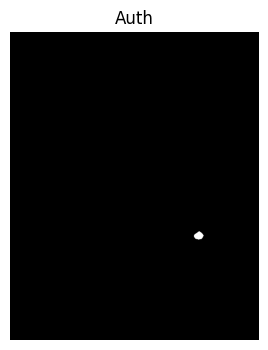

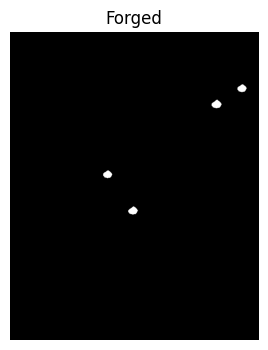

In [10]:
idx = 1

print(count_components_floodfill({"name":masked_entities[idx]["mask_name"], "index":masked_entities[idx]["index"], "bool_mask":masked_entities[idx]["auth_mask"]}))
print(masked_entities[idx]["auth_mask"].shape)

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(masked_entities[idx]["auth_mask"], cmap='gray')
plt.title(f'Auth')
plt.axis('off')

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(masked_entities[idx]["forged_mask"], cmap='gray')
plt.title(f'Forged')
plt.axis('off')

In [ ]:
# def auth_and_forged_sim_mat(auth_mask, forged_mask):
#     """
#     Calculate similarity matrix between authentic and forged patches using matrix multiplication
    
#     Args:
#         auth_mask: Boolean array of shape [H1, W1]
#         forged_mask: Boolean array of shape [H2, W2]
        
#     Returns:
#         similarity_matrix: Tensor of shape [H1, W1, H2, W2]
#     """
#     # Convert boolean masks to float tensors
#     if not isinstance(auth_mask, torch.Tensor):
#         auth_mask = torch.from_numpy(auth_mask.astype(np.float32))
#     if not isinstance(forged_mask, torch.Tensor):
#         forged_mask = torch.from_numpy(forged_mask.astype(np.float32))
    
#     # Get dimensions
#     H1, W1 = auth_mask.shape
#     H2, W2 = forged_mask.shape
    
#     # Reshape to [N1, 1] and [N2, 1] where N1 = H1*W1 and N2 = H2*W2
#     auth_features = auth_mask.reshape(-1, 1)
#     forged_features = forged_mask.reshape(-1, 1)
    
#     # Normalize features
#     auth_features = F.normalize(auth_features, p=2, dim=1)
#     forged_features = F.normalize(forged_features, p=2, dim=1)
    
#     # Calculate similarity matrix: [N1, 1] × [1, N2] = [N1, N2]
#     similarity_matrix = torch.matmul(auth_features, forged_features.T)
    
#     # Reshape to [H1, W1, H2, W2] for easier interpretation
#     similarity_matrix = similarity_matrix.reshape(H1, W1, H2, W2)
    
#     return similarity_matrix


# # Example usage:
# def visualize_similarity_matrix(similarity_matrix, title="Patch Similarity Matrix"):
#     """Visualize the similarity matrix with a heatmap"""
#     H1, W1, H2, W2 = similarity_matrix.shape
    
#     # Reshape to 2D for visualization
#     sim_mat_2d = similarity_matrix.reshape(H1*W1, H2*W2)
    
#     plt.figure(figsize=(100, 80))
#     plt.imshow(sim_mat_2d.cpu().numpy(), cmap='viridis', vmin=-1, vmax=1)
#     plt.colorbar(label='Cosine Similarity')
#     plt.title(title)
#     plt.xlabel('Forged Patches')
#     plt.ylabel('Authentic Patches')
#     plt.tight_layout()
#     plt.show()

# # Use with your data:
    
# # Calculate similarity matrix
# idx = 29
# similarity_matrix = auth_and_forged_sim_mat(
#     masked_entities[idx]["auth_mask"],
#     masked_entities[idx]["forged_mask"]
# )

# # Visualize
# visualize_similarity_matrix(
#     similarity_matrix,
#     f"Patch Similarity Matrix for {masked_entities[0]['mask_name']}"
# )

# # Optional: Find highest similarity matches
# max_similarities, max_indices = torch.max(similarity_matrix.reshape(-1, similarity_matrix.shape[-1]), dim=1)

# print(f"Top 5 highest similarities:")
# top_k = 5
# top_similarities, top_indices = torch.topk(max_similarities, top_k)

# for i, (sim, idx) in enumerate(zip(top_similarities, top_indices)):
#     auth_idx = idx // similarity_matrix.shape[-1]
#     forged_idx = idx % similarity_matrix.shape[-1]
#     print(f"{i+1}. Similarity: {sim:.3f}, Auth patch: {auth_idx}, Forged patch: {forged_idx}")

(512, 512)
(512, 512)


C:\Users\vishn\AppData\Local\Temp\ipykernel_17700\3971657101.py:86: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

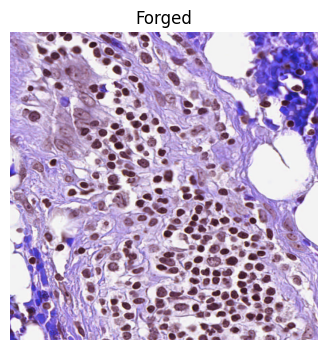

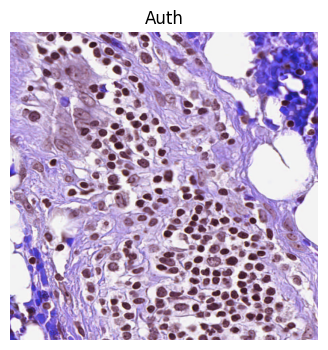

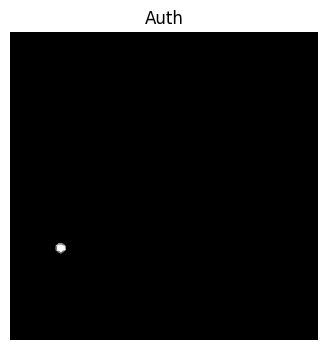

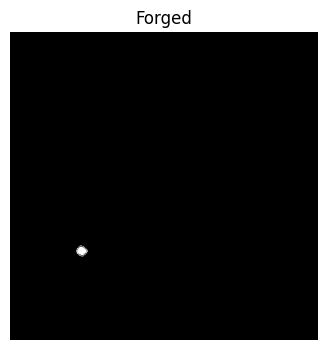

In [11]:
idx = 2
row = masked_entities[idx]

forged_image_path = os.path.join(forged_folder, row["mask_name"]+'.png')
forged_image = Image.open(forged_image_path).convert('RGB')

print(resize_image_to_fit_patch(forged_image).size)
# Forged
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(resize_image_to_fit_patch(forged_image))
plt.title(f'Forged')
plt.axis('off')


auth_image_path = os.path.join(authentic_folder, row["mask_name"]+'.png')
auth_image = Image.open(auth_image_path).convert('RGB')

# forged
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(resize_image_to_fit_patch(auth_image))
plt.title(f'Auth')
plt.axis('off')

print(resize_mask_to_fit_patch(row["auth_mask"]).shape)
# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(resize_mask_to_fit_patch(row["auth_mask"]), cmap='gray')
plt.title(f'Auth')
plt.axis('off')

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(resize_mask_to_fit_patch(row["forged_mask"]), cmap='gray')
plt.title(f'Forged')
plt.axis('off')

In [ ]:
BATCH_SIZE = 8
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def get_batches(batch_size:int = BATCH_SIZE):
    
    # Files
    files = glob(os.path.join("mask_entities", '*.pkl'))
    
    # Names
    names = {x.split(os.sep)[-1].split('_')[0] for x in files}
    
    i = 0
    while i < len(files):
        forged_img_tensors = []
        auth_mask_tensors = []
        forged_mask_tensors = []
        ids = []
        
        batch_files = files[i:i+batch_size]
        
        for file in batch_files:
            me = pickle.load(open(file, 'rb'))
            
            forged_image_path = os.path.join(forged_folder, me["mask_name"]+'.png')
            forged_img = Image.open(forged_image_path).convert('RGB')
            forged_img_resized = resize_image_to_fit_patch(forged_img)
            forged_img_tensor = TF.to_tensor(forged_img_resized)
            forged_image_normalized_tensor = TF.normalize(forged_img_tensor, \
                                        mean=IMAGENET_MEAN, \
                                        std=IMAGENET_STD)
            forged_img_tensors.append(forged_image_normalized_tensor)
            
            auth_mask = resize_mask_to_fit_patch(me["auth_mask"])
            auth_mask = pixel_mask_to_patch_float(auth_mask)
            auth_mask_tensor = torch.from_numpy(auth_mask).unsqueeze(0)
            auth_mask_tensors.append(auth_mask_tensor)
            
            forged_mask = resize_mask_to_fit_patch(me["forged_mask"])
            forged_mask = pixel_mask_to_patch_float(forged_mask)
            forged_mask_tensor = torch.from_numpy(forged_mask).unsqueeze(0)
            forged_mask_tensors.append(forged_mask_tensor)

            ids.append([me["mask_name"], me["index"]])
            
        forged_img_tensors = torch.stack(forged_img_tensors, dim=0)
        auth_mask_tensors = torch.stack(auth_mask_tensors, dim=0)
        forged_mask_tensors = torch.stack(forged_mask_tensors, dim=0)
        
        # yield forged_img_tensors, auth_mask_tensors, forged_mask_tensors, ids
        
        print(forged_img_tensors.shape, auth_mask_tensors.shape, forged_mask_tensors.shape)
        
        # return forged_img_tensors, auth_mask_tensors, forged_mask_tensors
        
        break
        
get_batches()

{'11223', '32162', '12261', '1041', '31783', '13742', '12879', '23510', '32714', '30217', '34528', '31040', '41462', '39740', '34873', '30624', '11548', '39015', '360', '19844', '25001', '30871', '41406', '41886', '41719', '12747', '22864', '18877', '24402', '37902', '24980', '40934', '42287', '17052', '31222', '37768', '29894', '36794', '10070', '40823', '42512', '17756', '35670', '40974', '3934', '16951', '4318', '20541', '42641', '38129', '11985', '20645', '14048', '2230', '28213', '38667', '40938', '32486', '42742', '13624', '13254', '27312', '32575', '1272', '38780', '37966', '35950', '39078', '14898', '11698', '16866', '19620', '26200', '34367', '24912', '24770', '39245', '21331', '38495', '35117', '34869', '13108', '32945', '40678', '28559', '37921', '27023', '12446', '12612', '28949', '14324', '28226', '18153', '30629', '29535', '19074', '16647', '31168', '25390', '35176', '40919', '35814', '24147', '20768', '31218', '2275', '21202', '28879', '35347', '12629', '37504', '13511',

C:\Users\vishn\AppData\Local\Temp\ipykernel_17700\3971657101.py:86: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')


torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 32, 32]) torch.Size([8, 1, 32, 32])


In [18]:

# Available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# we take DINOv3 ViT-H
# MODEL_NAME = MODEL_DINOV3_VITHP
MODEL_NAME = MODEL_DINOV3_VITB

model = torch.hub.load(
    repo_or_dir=dinov3_repo_dir,
    model=MODEL_NAME,
    source="local",
    weights=dinov3_vitb16_weight_raw, # dinov3_vitb16_weight_raw, #dinov3_vith16_weight_raw
)
model.cuda()

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

In [19]:
class SegmentationHead(nn.Module):
    def __init__(self, in_channels, hidden_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class DINOv3Segmentation(nn.Module):
    def __init__(self, backbone, depth=1, in_channels=768):  # 768 for ViT-B/16
        super().__init__()
        self.backbone = backbone
        self.seg_head = SegmentationHead(in_channels)
        self.depth = depth
        
        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # Initialize segmentation head
        for m in self.seg_head.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Get features from backbone
        features = self.backbone.get_intermediate_layers(
            x,
            n=range(n_layers),
            reshape=True,
            norm=True
        )
        last_layer_features = features[-1]  # Shape: [B, C, H, W]
        
        # Pass through segmentation head
        for d in range(self.depth):
            last_layer_features = self.seg_head(last_layer_features)
        return last_layer_features.permute(0, 2, 3, 1)

In [20]:


for img_batch, auth_batch, forged_batch, _ in tqdm(get_batches()):
    
    with torch.inference_mode(): 
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            
            layer_feats = model.get_intermediate_layers(img_batch.cuda(), \
                                                    n=range(n_layers), \
                                                    reshape=True, \
                                                    norm=True)
            
            patch_features = layer_feats[-1].detach().cpu()
            
            # Convert from [B, D, H, W] to [B, H, W, D]
            patch_features = patch_features.permute(0, 2, 3, 1)
            print(patch_features.shape)

            break

0it [00:00, ?it/s]C:\Users\vishn\AppData\Local\Temp\ipykernel_25252\853105895.py:86: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
0it [00:01, ?it/s]

torch.Size([8, 32, 32, 768])


In [7]:
class GramLoss(nn.Module):
    """Implementation of the gram loss"""

    def __init__(
        self,
        apply_norm=True,
        remove_neg=False,
        remove_only_teacher_neg=False,
    ):
        super().__init__()

        # Loss
        self.mse_loss = torch.nn.MSELoss()

        # Parameters
        self.apply_norm = apply_norm
        self.remove_neg = remove_neg
        self.remove_only_teacher_neg = remove_only_teacher_neg

        if self.remove_neg or self.remove_only_teacher_neg:
            assert self.remove_neg != self.remove_only_teacher_neg
            
    
    def auth_and_forged_sim_mat(self, auth_mask, forged_mask):
        """
        Calculate similarity matrix between authentic and forged patches using matrix multiplication
            
        Returns:
            similarity_matrix: Tensor of shape [H1, W1, H2, W2]
        """
        
        # Get dimensions
        B1, H1, W1 = auth_mask.shape
        B2, H2, W2 = forged_mask.shape
        
        # Patch correlation
        if self.apply_norm:
            auth_mask = F.normalize(auth_mask, dim=-1)
            forged_mask = F.normalize(forged_mask, dim=-1)
            
        similarity_matrix = torch.matmul(auth_mask, forged_mask.transpose(-1, -2))
        
        return similarity_matrix


    def forward(self, output_feats, auth_mask, forged_mask, img_level=True):
        """Compute the MSE loss between the gram matrix of the input and target features.
        Returns:
            loss: scalar
        """

        # Dimensions of the tensor should be (B, N, dim)
        if img_level:
            assert len(output_feats.shape) == 3
            
        target_sim = self.auth_and_forged_sim_mat(auth_mask, forged_mask)
        
        # print('target shape', target_sim.shape)

        # Patch correlation
        if self.apply_norm:
            output_feats = F.normalize(output_feats, dim=-1)

        if not img_level and len(output_feats.shape) == 3:
            # Flatten (B, N, D) into  (B*N, D)
            output_feats = output_feats.flatten(0, 1)
            
        # print(output_feats.shape)

        # Compute similarities
        student_sim = torch.matmul(output_feats, output_feats.transpose(-1, -2))
        
        # print(student_sim.shape)

        if self.remove_neg:
            target_sim[target_sim < 0] = 0.0
            student_sim[student_sim < 0] = 0.0

        elif self.remove_only_teacher_neg:
            # Remove only the negative sim values of the teacher
            target_sim[target_sim < 0] = 0.0
            student_sim[(student_sim < 0) & (target_sim < 0)] = 0.0

        return self.mse_loss(student_sim, target_sim)

In [8]:


# model.train()
# device = next(model.parameters()).device
gram_loss_fn = GramLoss(apply_norm=True, remove_neg=True)  

# optimizer = torch.optim.AdamW(
#     model.parameters(),
#     lr=1e-4,
#     weight_decay=0.05
# )

# Create segmentation model
seg_model = DINOv3Segmentation(model, in_channels=768).cuda()
seg_model.train()

# Create optimizer for segmentation head only
optimizer = torch.optim.AdamW(
    seg_model.seg_head.parameters(),  # Only optimize segmentation head
    lr=1e-4,
    weight_decay=0.05
)

for epoch in tqdm(range(10)):
    total_loss = 0.0
    
    # Zero gradients
    optimizer.zero_grad()
    
    for img_batch, auth_batch, forged_batch, _ in get_batches(batch_size=64):
        
        # Get model features
        with torch.amp.autocast_mode.autocast(device_type='cuda', dtype=torch.float32):
            
            seg_output = seg_model(img_batch.cuda())
            seg_output = seg_output.reshape(seg_output.shape[0], -1, seg_output.shape[-1]).float()
            
            auth_batch = auth_batch.cuda().permute(0, 2, 3, 1)
            auth_batch = auth_batch.reshape(auth_batch.shape[0], -1, auth_batch.shape[-1]).float()
            
            forged_batch = forged_batch.cuda().permute(0, 2, 3, 1)
            forged_batch = forged_batch.reshape(forged_batch.shape[0], -1, forged_batch.shape[-1]).float()
        
            # Calculate loss
            loss = gram_loss_fn(
                seg_output,
                auth_batch,
                forged_batch,
                img_level=True
            )
        
            # Backward pass
            loss.backward()
            optimizer.step()
            
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        
        # Update progress
        total_loss += loss.item()

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\vishn\AppData\Local\Temp\ipykernel_2336\853105895.py:86: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')


Epoch 0, Loss: 0.2530289590358734
Epoch 0, Loss: 0.20943206548690796
Epoch 0, Loss: 0.19018696248531342
Epoch 0, Loss: 0.1852024793624878
Epoch 0, Loss: 0.17794941365718842
Epoch 0, Loss: 0.18077218532562256
Epoch 0, Loss: 0.17534449696540833
Epoch 0, Loss: 0.17076849937438965
Epoch 0, Loss: 0.1691330373287201
Epoch 0, Loss: 0.16946616768836975
Epoch 0, Loss: 0.16732949018478394
Epoch 0, Loss: 0.16937336325645447
Epoch 0, Loss: 0.1685468554496765
Epoch 0, Loss: 0.17231053113937378
Epoch 0, Loss: 0.16770228743553162
Epoch 0, Loss: 0.1703324168920517
Epoch 0, Loss: 0.17039597034454346
Epoch 0, Loss: 0.1683916449546814
Epoch 0, Loss: 0.1690099984407425
Epoch 0, Loss: 0.1665291041135788
Epoch 0, Loss: 0.16443857550621033
Epoch 0, Loss: 0.16636532545089722
Epoch 0, Loss: 0.16338926553726196
Epoch 0, Loss: 0.1634281426668167
Epoch 0, Loss: 0.16214732825756073
Epoch 0, Loss: 0.16317814588546753
Epoch 0, Loss: 0.16179031133651733
Epoch 0, Loss: 0.160026416182518
Epoch 0, Loss: 0.15986838936805

  0%|          | 0/10 [27:45<?, ?it/s]


KeyboardInterrupt: 

In [8]:
# Save model checkpoint with training info
checkpoint = {
    'model_state_dict': seg_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'model_name': MODEL_NAME,
    'num_layers': n_layers
}

# Create checkpoints directory if it doesn't exist 
os.makedirs('checkpoints', exist_ok=True)

# Save checkpoint
checkpoint_path = os.path.join('weights', f'{MODEL_NAME}_dinov3_finetuned.pth')
torch.save(checkpoint, checkpoint_path)

print(f"Model checkpoint saved to {checkpoint_path}")

NameError: name 'seg_model' is not defined

In [21]:
# --- Loading ---
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    # Recreate model architecture
    model = torch.hub.load(
        repo_or_dir=dinov3_repo_dir,
        model=checkpoint['model_name'],
        source="local",
        weights=dinov3_vitb16_weight_raw,
    )
    seg_model = DINOv3Segmentation(model, in_channels=768).cuda()
    seg_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = torch.optim.AdamW(seg_model.seg_head.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return seg_model, optimizer

# Example usage:
checkpoint_path = os.path.join('weights', f'{MODEL_NAME}_dinov3_finetuned.pth')
seg_model, optimizer = load_checkpoint(checkpoint_path)

In [22]:
for img_batch, auth_batch, forged_batch, ids in tqdm(get_batches()):
    
    with torch.inference_mode(): 
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            
            print(img_batch.shape)
            layer_feats = seg_model(img_batch.cuda()).detach().cpu()
            print(patch_features.shape)

            break

0it [00:00, ?it/s]C:\Users\vishn\AppData\Local\Temp\ipykernel_25252\853105895.py:86: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')


torch.Size([8, 3, 512, 512])


0it [00:01, ?it/s]

torch.Size([8, 32, 32, 768])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


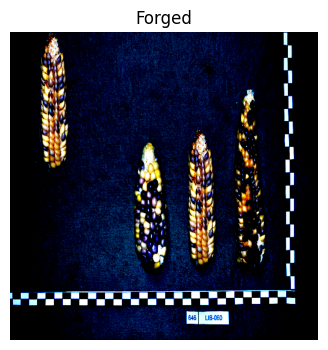

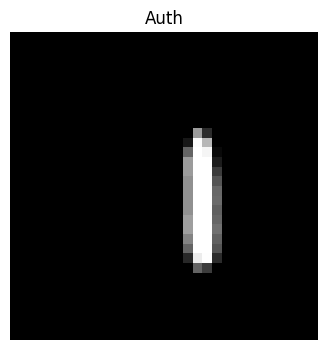

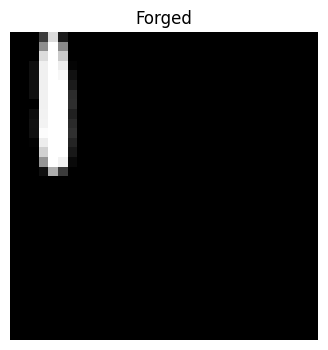

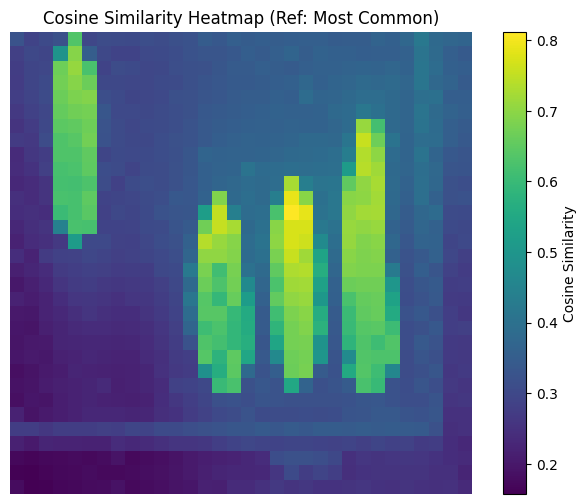

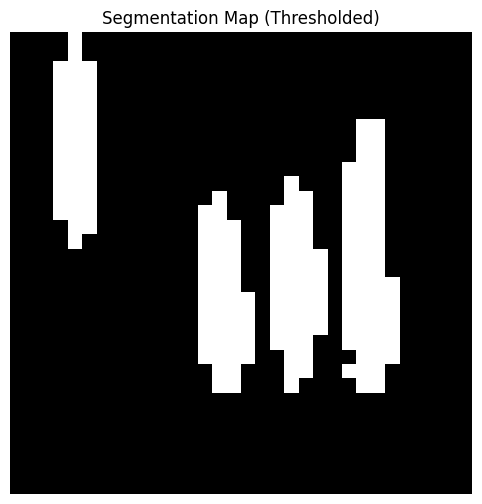

In [48]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def get_segmentation_map_from_features(feats, threshold=0.8, visualize=True):
    """
    Given a tensor of shape [H, W, D], compute a segmentation map based on cosine similarity
    to the most common feature vector (mode).
    """
    H, W, D = feats.shape
    feats_flat = feats.view(-1, D)  # [H*W, D]

    # --- CHANGE START ---
    # Find the most common vector (mode)
    # Note: For raw floating point features, you might want to round them first 
    # to increase overlaps, e.g.: rounded_feats = torch.round(feats_flat, decimals=2)
    rounded_feats =  torch.round(feats_flat, decimals=0)
    unique_vectors, counts = torch.unique(rounded_feats, return_counts=True, dim=0)
    # unique_vectors, counts = torch.unique(feats_flat, return_counts=True, dim=0)
    most_common_idx = torch.argmax(counts)
    ref_vec = unique_vectors[most_common_idx].unsqueeze(0)  # [1, D]
    # --- CHANGE END ---

    feats_norm = F.normalize(feats_flat, dim=1)
    ref_norm = F.normalize(ref_vec, dim=1)
    cos_sim = torch.matmul(feats_norm, ref_norm.t()).squeeze()  # [H*W]
    cos_sim_map = cos_sim.view(H, W)
    segmentation_map = (cos_sim_map > threshold).float()

    if visualize:
        plt.figure(figsize=(8, 6))
        plt.imshow(cos_sim_map.cpu().numpy(), cmap='viridis')
        plt.colorbar(label='Cosine Similarity')
        plt.title('Cosine Similarity Heatmap (Ref: Most Common)')
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.imshow(segmentation_map.cpu().numpy(), cmap='gray')
        plt.title('Segmentation Map (Thresholded)')
        plt.axis('off')
        plt.show()

    return segmentation_map, cos_sim_map

idx = 2

# Forged
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_batch[idx].squeeze(0).permute(1,2,0))
plt.title(f'Forged')
plt.axis('off')

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(auth_batch[idx].squeeze(0), cmap='gray')
plt.title(f'Auth')
plt.axis('off')

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(forged_batch[idx].squeeze(0), cmap='gray')
plt.title(f'Forged')
plt.axis('off')

# Example usage:
seg_map, sim_map = get_segmentation_map_from_features(patch_features[idx], threshold=0.50)



In [41]:
import json

import numba
import numpy as np
from numba import types
import numpy.typing as npt
import pandas as pd
import scipy.optimize


class ParticipantVisibleError(Exception):
    pass


@numba.jit(nopython=True)
def _rle_encode_jit(x: npt.NDArray, fg_val: int = 1) -> list[int]:
    """Numba-jitted RLE encoder."""
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def rle_encode(masks: list[npt.NDArray], fg_val: int = 1) -> str:
    """
    Adapted from contrails RLE https://www.kaggle.com/code/inversion/contrails-rle-submission
    Args:
        masks: list of numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encodings as a string, with each RLE JSON-encoded and separated by a semicolon.
    """
    return ';'.join([json.dumps(_rle_encode_jit(x, fg_val)) for x in masks])


@numba.njit
def _rle_decode_jit(mask_rle: npt.NDArray, height: int, width: int) -> npt.NDArray:
    """
    s: numpy array of run-length encoding pairs (start, length)
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if len(mask_rle) % 2 != 0:
        # Numba requires raising a standard exception.
        raise ValueError('One or more rows has an odd number of values.')

    starts, lengths = mask_rle[0::2], mask_rle[1::2]
    starts -= 1
    ends = starts + lengths
    for i in range(len(starts) - 1):
        if ends[i] > starts[i + 1]:
            raise ValueError('Pixels must not be overlapping.')
    img = np.zeros(height * width, dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img


def rle_decode(mask_rle: str, shape: tuple[int, int]) -> npt.NDArray:
    """
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """

    mask_rle = json.loads(mask_rle)
    mask_rle = np.asarray(mask_rle, dtype=np.int32)
    starts = mask_rle[0::2]
    if sorted(starts) != list(starts):
        raise ParticipantVisibleError('Submitted values must be in ascending order.')
    try:
        return _rle_decode_jit(mask_rle, shape[0], shape[1]).reshape(shape, order='F')
    except ValueError as e:
        raise ParticipantVisibleError(str(e)) from e


def calculate_f1_score(pred_mask: npt.NDArray, gt_mask: npt.NDArray):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    tp = np.sum((pred_flat == 1) & (gt_flat == 1))
    fp = np.sum((pred_flat == 1) & (gt_flat == 0))
    fn = np.sum((pred_flat == 0) & (gt_flat == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0


def calculate_f1_matrix(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Parameters:
    pred_masks (np.ndarray):
            First dimension is the number of predicted instances.
            Each instance is a binary mask of shape (height, width).
    gt_masks (np.ndarray):
            First dimension is the number of ground truth instances.
            Each instance is a binary mask of shape (height, width).
    """

    num_instances_pred = len(pred_masks)
    num_instances_gt = len(gt_masks)
    f1_matrix = np.zeros((num_instances_pred, num_instances_gt))

    # Calculate F1 scores for each pair of predicted and ground truth masks
    for i in range(num_instances_pred):
        for j in range(num_instances_gt):
            pred_flat = pred_masks[i].flatten()
            gt_flat = gt_masks[j].flatten()
            f1_matrix[i, j] = calculate_f1_score(pred_mask=pred_flat, gt_mask=gt_flat)

    if f1_matrix.shape[0] < len(gt_masks):
        # Add a row of zeros to the matrix if the number of predicted instances is less than ground truth instances
        f1_matrix = np.vstack((f1_matrix, np.zeros((len(gt_masks) - len(f1_matrix), num_instances_gt))))

    return f1_matrix


def oF1_score(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Calculate the optimal F1 score for a set of predicted masks against
    ground truth masks which considers the optimal F1 score matching.
    This function uses the Hungarian algorithm to find the optimal assignment
    of predicted masks to ground truth masks based on the F1 score matrix.
    If the number of predicted masks is less than the number of ground truth masks,
    it will add a row of zeros to the F1 score matrix to ensure that the dimensions match.

    Parameters:
    pred_masks (list of np.ndarray): List of predicted binary masks.
    gt_masks (np.ndarray): Array of ground truth binary masks.
    Returns:
    float: Optimal F1 score.
    """
    f1_matrix = calculate_f1_matrix(pred_masks, gt_masks)

    # Find the best matching between predicted and ground truth masks
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-f1_matrix)
    # The linear_sum_assignment discards excess predictions so we need a separate penalty.
    excess_predictions_penalty = len(gt_masks) / max(len(pred_masks), len(gt_masks))
    return np.mean(f1_matrix[row_ind, col_ind]) * excess_predictions_penalty


def evaluate_single_image(label_rles: str, prediction_rles: str, shape_str: str) -> float:
    shape = json.loads(shape_str)
    label_rles = [rle_decode(x, shape=shape) for x in label_rles.split(';')]
    prediction_rles = [rle_decode(x, shape=shape) for x in prediction_rles.split(';')]
    return oF1_score(prediction_rles, label_rles)


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Args:
        solution (pd.DataFrame): The ground truth DataFrame.
        submission (pd.DataFrame): The submission DataFrame.
        row_id_column_name (str): The name of the column containing row IDs.
    Returns:
        float

    Examples
    --------
    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 103]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.9983739837398374

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102];[300, 100]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.8333333333333334
    """
    df = solution
    df = df.rename(columns={'annotation': 'label'})

    df['prediction'] = submission['annotation']
    # Check for correct 'authentic' label
    authentic_indices = (df['label'] == 'authentic') | (df['prediction'] == 'authentic')
    df['image_score'] = ((df['label'] == df['prediction']) & authentic_indices).astype(float)

    df.loc[~authentic_indices, 'image_score'] = df.loc[~authentic_indices].apply(
        lambda row: evaluate_single_image(row['label'], row['prediction'], row['shape']), axis=1
    )
    return float(np.mean(df['image_score']))

In [46]:
rle_encode([seg_map.numpy()])

'[99, 11, 129, 14, 163, 12, 430, 10, 460, 14, 494, 12, 590, 3, 595, 1, 619, 14, 652, 13, 748, 6, 775, 14, 808, 13]'

In [43]:
seg_map.shape

torch.Size([32, 32])

In [44]:
seg_map > 0

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])